# Word 2 vec and LDA2vec

## word 2 vec - use 'side effect' as pivot word

In [1]:
## for data
import pandas as pd
import numpy as np#

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers
import simpletransformers

### read in data

In [4]:
### load labeled data

data = pd.read_csv('../raw_data/drugsComTrain_raw.csv')

#data = data[data['rating'] < 5]
#data["sideEffect"] = data["sideEffect"].astype(int)
data = data.reset_index(drop = True)
data = data.sort_values(by=['drugName'])
data = data.reset_index(drop = True)
data = data.drop(["uniqueID", "date", "usefulCount"], axis = 1)
# print(pd.DataFrame(data["drugName"].value_counts()))

data.tail()

,drugName,condition,review,rating
161292,ella,Emergency Contraception,"""Had a small accident early hours of 18th June...",8
161293,ella,Emergency Contraception,"""So I took Ellaone when I wasn&rsquo;t quite s...",4
161294,femhrt,0</span> users found this comment helpful.,"""I was on femHRT for four months and had BV (b...",1
161295,femhrt,Acne,"""Recently switched from birth conrtol which ke...",1
161296,femhrt,Postmenopausal Symptoms,"""This medication completely changed my life fo...",10


In [5]:
## check for nans

#data = data.dropna()
data.isnull().sum()

drugName       0
condition    899
review         0
rating         0
dtype: int64

## preprocessing

In [8]:
### define preprocessing utlities function

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [6]:
### download stopwords

lst_stopwords = nltk.corpus.stopwords.words("english")

In [9]:
### creat cleaned text column

data["review_clean"] = data["review"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

data.tail()

,drugName,condition,review,rating,review_clean
161292,ella,Emergency Contraception,"""Had a small accident early hours of 18th June...",8,small accident early hour 18th june took ella ...
161293,ella,Emergency Contraception,"""So I took Ellaone when I wasn&rsquo;t quite s...",4,took ellaone wasnrsquot quite sure done ovulat...
161294,femhrt,0</span> users found this comment helpful.,"""I was on femHRT for four months and had BV (b...",1,femhrt four month bv bacterial vaginitis four ...
161295,femhrt,Acne,"""Recently switched from birth conrtol which ke...",1,recently switched birth conrtol kept skin shap...
161296,femhrt,Postmenopausal Symptoms,"""This medication completely changed my life fo...",10,medication completely changed life better also...


## apply word 2 vec

### run on clean data

In [11]:
corpus = data["review_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)

trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
                              delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [12]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

In [18]:
similar_words = nlp.most_similar('effect')
print(similar_words)


[('side', 0.7931192517280579), ('affect', 0.6203980445861816), ('eefects', 0.618613064289093), ('noodlyquot', 0.6174300312995911), ('ssrisnrissnri', 0.6100465059280396), ('quotwet', 0.6070297956466675), ('ummoodiness', 0.5969613790512085), ('stiffsore', 0.5968961715698242), ('amout', 0.592865526676178), ('nuvaringthe', 0.5908069014549255)]


/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


In [33]:
vocab = list(nlp.wv.vocab) 
vocab_df = pd.DataFrame(vocab)
vocab_df.head()

,0
0,severe
1,cracked
2,skin
3,hand
4,i039ve


In [38]:
similar = nlp.most_similar('side', 'effect')
print(similar)

/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


KeyError: "word 'i' not in vocabulary"

/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


<Figure size 432x288 with 0 Axes>

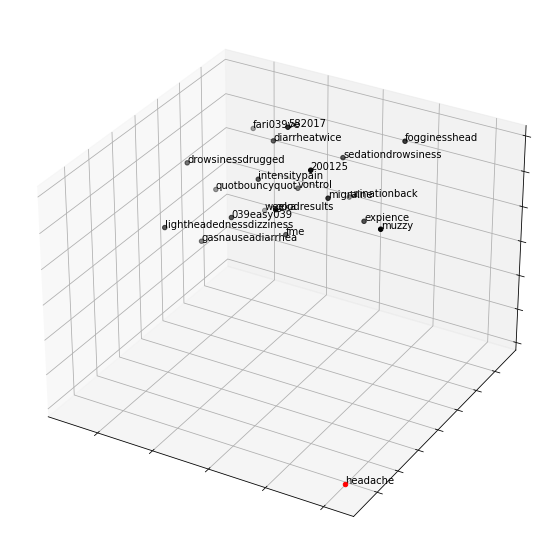

In [41]:
### visual word in x dimensional space

word = "headache"
fig = plt.figure()

## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]

## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1

## plot 3d
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(11, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

In [ ]:
### run on cleaned data minus stop words

